In [2]:
#!pip install openpyxl

In [3]:
import datetime
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import openpyxl as openpyxl
import gcsfs
fs = gcsfs.GCSFileSystem()

In [ ]:
#Search LEAP persistent bucket
#fs.ls('gs://leap-persistent/')

# Fluxes from Global Carbon Budget

In [4]:
df = pd.read_excel('/home/jovyan/Global_Carbon_Budget_2023v1.0.xlsx', sheet_name='Ocean Sink', skiprows=range(0, 30))
df = df.drop(columns=['Unnamed: 3'])

In [6]:
df

,year,GCB,1 sigma uncertainty,NEMO3.6-PISCESv2-gas (CNRM),FESOM-2.1-REcoM3,NEMO-PISCES (IPSL),MOM6-COBALT (Princeton),MRI-ESM2-21,MICOM-HAMOCC (NorESM1-OCv1.2),NEMO-PlankTOM12,...,CMEMS-LSCE-FFNN,JMA-MLR,LDEO-HPD,MPI-SOMFFN,NIES-ML3,OS_ETH_Gracer,Jena-MLS,UOEx-Watson,Average data-products (excl. Watson.),sd data-products (excl. Watson.)
0,1959,0.992420,0.4,0.569600,1.081598,0.802233,0.329736,0.826969,1.080654,0.912024,...,NaN,NaN,0.783034,NaN,NaN,NaN,0.691750,NaN,NaN,NaN
1,1960,0.936514,0.4,0.448784,1.061996,0.682631,0.461235,0.891830,1.059714,0.760485,...,NaN,NaN,0.779510,NaN,NaN,NaN,0.761025,NaN,NaN,NaN
2,1961,0.839509,0.4,0.285968,0.932394,0.561028,0.313734,0.753690,0.986774,0.773946,...,NaN,NaN,0.742605,NaN,NaN,NaN,0.577939,NaN,NaN,NaN
3,1962,0.923603,0.4,0.408153,0.923792,0.589426,0.406232,0.829551,1.156834,0.741407,...,NaN,NaN,0.770246,NaN,NaN,NaN,0.643668,NaN,NaN,NaN
4,1963,1.111698,0.4,0.618337,1.023190,0.787824,0.607731,1.117412,1.339894,0.982868,...,NaN,NaN,1.021941,NaN,NaN,NaN,0.887813,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,2018,2.907491,0.4,2.241476,2.884091,2.327707,2.295175,2.531745,3.010200,2.449226,...,3.148010,3.387824,3.260680,3.217401,2.720536,3.352288,3.452428,4.031786,3.219881,0.243583
60,2019,2.955932,0.4,2.217660,2.893489,2.183105,2.417674,2.476605,3.054260,2.478687,...,3.329855,3.537682,3.432679,3.276845,2.736034,3.451004,3.527469,4.005805,3.327367,0.277754
61,2020,2.914365,0.4,2.323844,2.864887,2.005503,2.442173,2.385466,2.975320,2.432148,...,3.349919,3.658239,3.165337,3.225723,2.686098,3.257657,3.433908,4.013805,3.253840,0.298932
62,2021,2.825585,0.4,2.017029,2.724285,1.887901,2.245672,2.417326,3.089380,2.340609,...,3.294870,3.530012,3.175894,3.341010,2.550645,3.200430,3.097032,3.926537,3.169985,0.306684


In [5]:
test = pd.DataFrame(df).to_xarray()

In [6]:
models = xr.DataArray([test['NEMO3.6-PISCESv2-gas (CNRM)'],test['FESOM-2.1-REcoM3'],test['NEMO-PISCES (IPSL)'],test['MOM6-COBALT (Princeton)'],test['MRI-ESM2-21'],test['MICOM-HAMOCC (NorESM1-OCv1.2)'],test['NEMO-PlankTOM12'],test['CESM-ETHZ'],test['MPIOM-HAMOCC6'],test['ACCESS (CSIRO)']])
products = xr.DataArray([test['CMEMS-LSCE-FFNN'],test['JMA-MLR'],test['MPI-SOMFFN'],test['NIES-ML3'],test['OS_ETH_Gracer'],test['UOEx-Watson'],test['Jena-MLS'],test['LDEO-HPD']])
products_nowatson = xr.DataArray([test['CMEMS-LSCE-FFNN'],test['JMA-MLR'],test['MPI-SOMFFN'],test['NIES-ML3'],test['OS_ETH_Gracer'],test['Jena-MLS'],test['LDEO-HPD']])

In [7]:
models = models.rename({'dim_0': 'model','dim_1': 'years'})
products = products.rename({'dim_0': 'product','dim_1': 'years'})
products_nowatson = products_nowatson.rename({'dim_0': 'product','dim_1': 'years'})

In [8]:
models = models.assign_coords({"years": test.year.values})
products = products.assign_coords({"years": test.year.values})
products_nowatson = products_nowatson.assign_coords({"years": test.year.values})

In [9]:
product_mean = (products_nowatson.mean('product')*-1)
product_std = products_nowatson.std('product')
product_min = (products_nowatson.min(dim='product')*-1)
product_max = (products_nowatson.max(dim='product')*-1)

model_mean = (models.mean('model')*-1)
model_std = models.std('model')
model_min = (models.min(dim='model')*-1)
model_max = (models.max(dim='model')*-1)

## pCO2-Residual reconstructions

In [10]:
path_orig = f'gs://leap-persistent/galenmckinley/reconstructions/pCO2_LEAP_fco2-residual-flux-monthly-3winds-summary_198201-202212.zarr'
path_opt = f'gs://leap-persistent/hatlenheimdalthea/fco2_residual_real_recon/pCO2_LEAP_fco2-residual-flux-monthly-3winds-summary_198201-202212.zarr'

flux_file_yearly_orig_params = xr.open_dataset(path_orig, engine='zarr')
flux_file_yearly_opt_params = xr.open_dataset(path_opt, engine='zarr')

In [11]:
river_carbon_adjustment = 0.65   #adjustment to be applied on products for comparison to GOBMs

plot_data_orig = flux_file_yearly_orig_params.flux.groupby("time.year").mean("time").mean('wind')/1e15 - river_carbon_adjustment
plot_data_val = flux_file_yearly_opt_params.flux.groupby("time.year").mean("time").mean('wind')/1e15 - river_carbon_adjustment

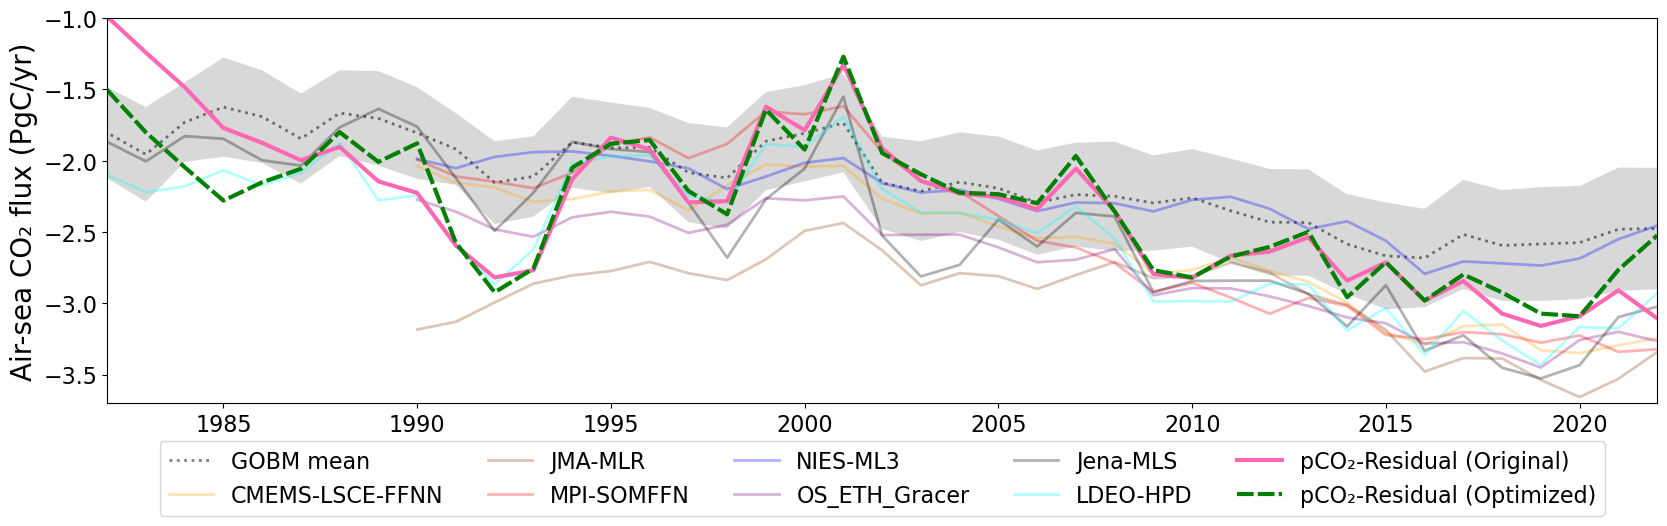

In [12]:
fig = plt.figure(figsize=(20,5))

plt.plot(range(1959,2023),model_mean,'black',linewidth=2,label='GOBM mean', alpha=0.5, linestyle='dotted')
plt.fill_between(range(1959,2023), (model_mean)-(model_std), (model_mean)+(model_std) ,alpha=0.3, facecolor='gray')

plt.plot(range(1959,2023),products_nowatson.isel(product=0)*-1, color = 'orange',linewidth=2,label = 'CMEMS-LSCE-FFNN',alpha=0.3)#
plt.plot(range(1959,2023),products_nowatson.isel(product=1)*-1, color = 'saddlebrown',linewidth=2,label = 'JMA-MLR',alpha=0.3)
plt.plot(range(1959,2023),products_nowatson.isel(product=2)*-1, color = 'red',linewidth=2,label = 'MPI-SOMFFN',alpha=0.3)
plt.plot(range(1959,2023),products_nowatson.isel(product=3)*-1, color = 'blue',linewidth=2,label = 'NIES-ML3',alpha=0.3)
plt.plot(range(1959,2023),products_nowatson.isel(product=4)*-1, color = 'purple',linewidth=2,label = 'OS_ETH_Gracer',alpha=0.3)
plt.plot(range(1959,2023),products_nowatson.isel(product=5)*-1, color = 'black',linewidth=2,label = 'Jena-MLS',alpha=0.3)
plt.plot(range(1959,2023),products_nowatson.isel(product=6)*-1, color = 'cyan',linewidth=2,label = 'LDEO-HPD',alpha=0.3)

plt.plot(flux_file_yearly_orig_params.year,plot_data_orig,linewidth=3.0,c='hotpink',label='pCO\u2082-Residual (Original)')
plt.plot(flux_file_yearly_opt_params.year,plot_data_val,linewidth=3.0,c='green',label='pCO\u2082-Residual (Optimized)', linestyle='dashed', dashes=(4, 1))


plt.ylim([-3.7,-1.0])
plt.xlim([1982,2022])
plt.tick_params(labelsize=16)
plt.ylabel('Air-sea CO\u2082 flux (PgC/yr)', size=20);
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07), ncol=5, fontsize=16); #fancybox=True, shadow=True,

#fig.savefig("/home/jovyan/timeseries_fluxes.jpg",dpi=300, bbox_inches="tight");

### Calculate mean annual flux

In [13]:
orig = flux_file_yearly_orig_params.annual_flux
opt = flux_file_yearly_opt_params.annual_flux

river_carbon_adjustment = 0.65  
orig_test = orig.mean(['wind'])/1e15- river_carbon_adjustment
opt_test = opt.mean(['wind'])/1e15- river_carbon_adjustment

print(orig_test)
print(opt_test)